In [1]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [2]:
from langgraph.graph import END, StateGraph
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, AnyMessage, ToolMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from typing import TypedDict, List, Annotated
import operator
from langchain_groq import ChatGroq
from IPython.display import display, Image

State

In [3]:
class AgentState(TypedDict):
    messages:Annotated[list[AnyMessage], operator.add]

Prepare Tools

In [4]:
search = TavilySearchResults(max_results=3)

C:\Users\badho\AppData\Local\Temp\ipykernel_17840\1731400840.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search = TavilySearchResults(max_results=3)


In [5]:
search.invoke("What is LangGraph?")

[{'title': 'What is LangGraph? - GeeksforGeeks',
  'url': 'https://www.geeksforgeeks.org/machine-learning/what-is-langgraph/',
  'content': '# What is LangGraph?\n\nLast Updated : \n10 Oct, 2025\n\nSuggest changes\n\n1 Likes\n\nLangGraph is an open-source framework built by LangChain that streamlines the creation and management of AI agent workflows. At its core, LangGraph combines large language models (LLMs) with graph-based architectures allowing developers to map, organize and optimize how AI agents interact and make decisions.',
  'score': 0.9542783},
 {'title': 'LangGraph overview - Docs by LangChain',
  'url': 'https://docs.langchain.com/oss/python/langgraph/overview',
  'content': 'Trusted by companies shaping the future of agents— including Klarna, Replit, Elastic, and more— LangGraph is a low-level orchestration framework and runtime for building, managing, and deploying long-running, stateful agents. LangGraph is very low-level, and focused entirely on agent orchestration. B

Prepare Agent

In [6]:
class Agent:
    def __init__(self, llm, tools, system_message: str, checkpointer=None):
        self.llm = llm
        self.system_message = system_message
        self.llm = self.llm.bind_tools(tools)
        self.tools = {tool.name: tool for tool in tools}


        graph = StateGraph(AgentState)
        graph.add_node("llm", self.do_action)
        graph.add_node("tool_call", self.tool_call)
        graph.set_entry_point("llm")
        graph.add_conditional_edges("llm",
                self.contine_graph,
                {
                    True: "tool_call",
                    False: END
                })
        graph.add_edge("tool_call", "llm")
        if checkpointer:
            self.graph = graph.compile(checkpointer=checkpointer)
        else:
            self.graph = graph.compile()


    def do_action(self, state:AgentState)->AgentState:
         if self.system_message:
            messages = [SystemMessage(content=self.system_message)] + state['messages']
         else:
            messages = state['messages']
         res = self.llm.invoke(messages)

         print("LLM Response:")
         if res.content=="":
             print("I need additional information to answer that.", res.additional_kwargs)
         else:
             print(res.content)
         print("end LLM Response")

         return {"messages": [res]}
    
    
    def tool_call(self, state:AgentState)->AgentState:

        tool_results = []
        last_message = state['messages'][-1]

        if not len(last_message.tool_calls):
            raise ValueError("No tool calls found in the last message.")
        
        for tool_call in last_message.tool_calls:
            print(f"Invoking tool: {tool_call['name']} with query: {tool_call['args']['query']}")
            if tool_call['name'] in self.tools:
                print("Tool found, invoking...")
                res = self.tools[tool_call['name']].invoke(tool_call['args']['query'])
                tool_results.append(ToolMessage(content=str(res), name=tool_call['name'], tool_call_id=tool_call['id']))

            else:
                raise ValueError(f"Tool {tool_call['name']} not found.")
        return {"messages": tool_results}
    
    def contine_graph(self, state:AgentState):
        
        return len(state['messages'][-1].tool_calls) > 0
        

Model

In [7]:
llm = ChatGroq(model = "llama-3.1-8b-instant")

In [8]:
agent = Agent(llm, tools=[search], system_message="You are a helpful assistant.")

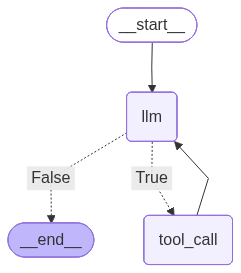

In [9]:
display(Image(agent.graph.get_graph().draw_mermaid_png()))

In [10]:
result = agent.graph.invoke({'messages': [HumanMessage(content="What is the current temperature in SF?")]})

LLM Response:
I need additional information to answer that. {'tool_calls': [{'id': '44b115zjt', 'function': {'arguments': '{"query":"current temperature in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}
end LLM Response
Invoking tool: tavily_search_results_json with query: current temperature in San Francisco
Tool found, invoking...
LLM Response:
Based on the search results, the current temperature in San Francisco is around 75°.
end LLM Response


In [11]:
result = agent.graph.invoke({'messages': [HumanMessage(content="What about in SF?")]})

LLM Response:
I need additional information to answer that. {'tool_calls': [{'id': '4xg3j212z', 'function': {'arguments': '{"query":"San Francisco weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}
end LLM Response
Invoking tool: tavily_search_results_json with query: San Francisco weather
Tool found, invoking...
LLM Response:
Based on the search results, the current weather in San Francisco is mostly sunny with a high of 65°F and a low of 53°F. The weather forecast for the next few days is also mostly sunny with highs in the mid-60s to low 70s and lows in the mid-50s to low 60s. There is a chance of precipitation on November 5.
end LLM Response


As expected, if the conversations need to continue over multiple invocations, additional memory is required.

Persistence Memory

In [196]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

In [18]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [19]:
thread = {"configurable": {"thread_id": "1"}}

In [23]:
thread2 = {"configurable": {"thread_id": "2"}}

In [20]:
intelligent_agent = Agent(llm, tools=[search], system_message="You are a helpful assistant.", checkpointer=memory)

In [21]:
result = intelligent_agent.graph.invoke({'messages': [HumanMessage(content="What is the current temperature in Dhaka?")]}, config= thread)

LLM Response:
I need additional information to answer that. {'tool_calls': [{'id': '5yejfzzsa', 'function': {'arguments': '{"query":"Dhaka current temperature"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}
end LLM Response
Invoking tool: tavily_search_results_json with query: Dhaka current temperature
Tool found, invoking...
LLM Response:
The current temperature in Dhaka is 78°F (25°C) according to Time and Date. However, it's worth noting that the temperature may vary depending on the source and the time of day. AccuWeather also reports a high of 86°F (30°C) for the day and a low of 67°F (19°C) for the night. It's always a good idea to check multiple sources for the most up-to-date and accurate information.
end LLM Response


In [22]:
result = intelligent_agent.graph.invoke({'messages': [HumanMessage(content="What about in Berlin?")]}, config= thread)

LLM Response:
I need additional information to answer that. {'tool_calls': [{'id': 'x93etz9gq', 'function': {'arguments': '{"query":"Berlin current temperature"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}
end LLM Response
Invoking tool: tavily_search_results_json with query: Berlin current temperature
Tool found, invoking...
LLM Response:
The current temperature in Berlin is 46°F (8°C) according to Time and Date. However, it's worth noting that the temperature may vary depending on the source and the time of day. AccuWeather also reports a high of 48°F (9°C) for the day and a low of 44°F (7°C) for the night.
end LLM Response


Now, LLM has the contexts of the previou requests. :)

Try with different thread

In [24]:
result = intelligent_agent.graph.invoke({'messages': [HumanMessage(content="What about in Berlin?")]}, config= thread2)

LLM Response:
I need additional information to answer that. {'tool_calls': [{'id': 'vf0gcf3b8', 'function': {'arguments': '{"query":"current events in Berlin"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}
end LLM Response
Invoking tool: tavily_search_results_json with query: current events in Berlin
Tool found, invoking...
LLM Response:
It seems there are several current events in Berlin. The AfD is ahead of the Greens in Berlin for the first time, and there are concerns about housing security and rent control regulations. There are also several upcoming events and changes affecting expats in Germany, such as the start of Christmas market season and the implementation of the EU's Gigabit Infrastructure Act. Additionally, Ryanair has scrapped paper boarding passes.
end LLM Response


This time, it provides info about events, as there is no conversation related to weather in this thread

## Streaming.....

In [25]:
messages =  [HumanMessage(content="Is it raining in Erlangen?")]
for event in intelligent_agent.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v['messages'])

LLM Response:
I need additional information to answer that. {'tool_calls': [{'id': 'vtbdd3wy1', 'function': {'arguments': '{"query":"Erlangen weather rain"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}
end LLM Response
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'vtbdd3wy1', 'function': {'arguments': '{"query":"Erlangen weather rain"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 3316, 'total_tokens': 3338, 'completion_time': 0.019766705, 'prompt_time': 0.185015062, 'queue_time': 0.090131311, 'total_time': 0.204781767}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ab04adca7d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--eb5d5597-b587-41cd-8b89-cb854c93b77e-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Erlangen weather rain'}, 'id': 'vtbdd3wy1', 'type': 'tool_call'}]

### Streaming tokens

In [30]:
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver

asyn_memory = AsyncSqliteSaver.from_conn_string(":memory:")


In [41]:
asyn_agent = Agent(llm, tools=[search], system_message="You are a helpful assistant.")

In [42]:
asyn_thread = {"configurable": {"thread_id": "async_1"}}

In [43]:
asyn_agent.graph.invoke({'messages': [HumanMessage(content="What is the current temperature in Tokyo?")]}, asyn_thread)

LLM Response:
I need additional information to answer that. {'tool_calls': [{'id': 'vnk4c0n5c', 'function': {'arguments': '{"query":"Tokyo current temperature"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}
end LLM Response
Invoking tool: tavily_search_results_json with query: Tokyo current temperature
Tool found, invoking...
LLM Response:
The current temperature in Tokyo is around 51°F (10°C).
end LLM Response


{'messages': [HumanMessage(content='What is the current temperature in Tokyo?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'vnk4c0n5c', 'function': {'arguments': '{"query":"Tokyo current temperature"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 292, 'total_tokens': 313, 'completion_time': 0.029482087, 'prompt_time': 0.015915032, 'queue_time': 0.08828145, 'total_time': 0.045397119}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ab04adca7d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--f1840e45-15c5-4edb-a363-1e0292e984a6-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Tokyo current temperature'}, 'id': 'vnk4c0n5c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 292, 'output_tokens': 21, 'total_tokens': 313}),
  ToolMessage(content='

In [46]:
messages = [HumanMessage(content="What is the latest version of vLLM?")]
async for event in asyn_agent.graph.astream_events({"messages": messages}, asyn_thread, version="v1"):
    kind = event["event"]
    if kind == "on_chat_model_stream":
        content = event["data"]["chunk"].content
        if content:
            print(content, end="|")

LLM Response:
I need additional information to answer that. {'tool_calls': [{'index': 0, 'id': 'agk4d24sm', 'function': {'arguments': '{"query":"vLLM latest version"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}
end LLM Response
Invoking tool: tavily_search_results_json with query: vLLM latest version
Tool found, invoking...
The| latest| version| of| v|LL|M| is| |0|.|11|.|0|.|LLM Response:
The latest version of vLLM is 0.11.0.
end LLM Response


Approach 2 (Persistence)

In [38]:
from langgraph.checkpoint.sqlite import SqliteSaver


In [40]:
with SqliteSaver.from_conn_string(":memory:") as memory:
  asyn_agent = Agent(llm, tools=[search], system_message="You are a helpful assistant.", checkpointer=memory)
  messages = [HumanMessage(content="What is the weather in Dhaka?")]
  thread = {"configurable": {"thread_id": "5"}}
  
  for event in asyn_agent.graph.stream({"messages": messages}, thread):
      for v in event.values():
          print(v['messages'])


LLM Response:
I need additional information to answer that. {'tool_calls': [{'id': 'nw2bjwvp3', 'function': {'arguments': '{"query":"Dhaka weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}
end LLM Response
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'nw2bjwvp3', 'function': {'arguments': '{"query":"Dhaka weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 292, 'total_tokens': 313, 'completion_time': 0.029502156, 'prompt_time': 0.01613738, 'queue_time': 0.091813453, 'total_time': 0.045639536}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ab04adca7d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a34be406-1680-4607-a8f6-1cc8fa65c8a7-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Dhaka weather'}, 'id': 'nw2bjwvp3', 'type': 'tool_call'}], usage_metadata={'input_to